In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def rle_decode(mask_rle, shape=(1280, 1918, 1)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)

    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths    
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
        
    img = img.reshape(shape)
    return img

In [ ]:
df = pd.read_csv('/content/drive/My Drive/data/train_masks.csv')
df.shape

(5088, 2)

In [ ]:
train_df = df[:4000]
val_df = df[4000:]

In [ ]:
def keras_generator(gen_df, batch_size):
    while True:
        x_batch = []
        y_batch = []
        
        for i in range(batch_size):
            img_name, mask_rle = gen_df.sample(1).values[0]
            img = cv2.imread('/content/drive/My Drive/data/train/{}'.format(img_name))
            mask = rle_decode(mask_rle)
            
            img = cv2.resize(img, (256, 256))
            mask = cv2.resize(mask, (256, 256))
            
            
            x_batch += [img]
            y_batch += [mask]

        x_batch = np.array(x_batch) / 255.
        y_batch = np.array(y_batch)

        yield x_batch, np.expand_dims(y_batch, -1)

In [ ]:
for x, y in keras_generator(train_df, 8):
    break

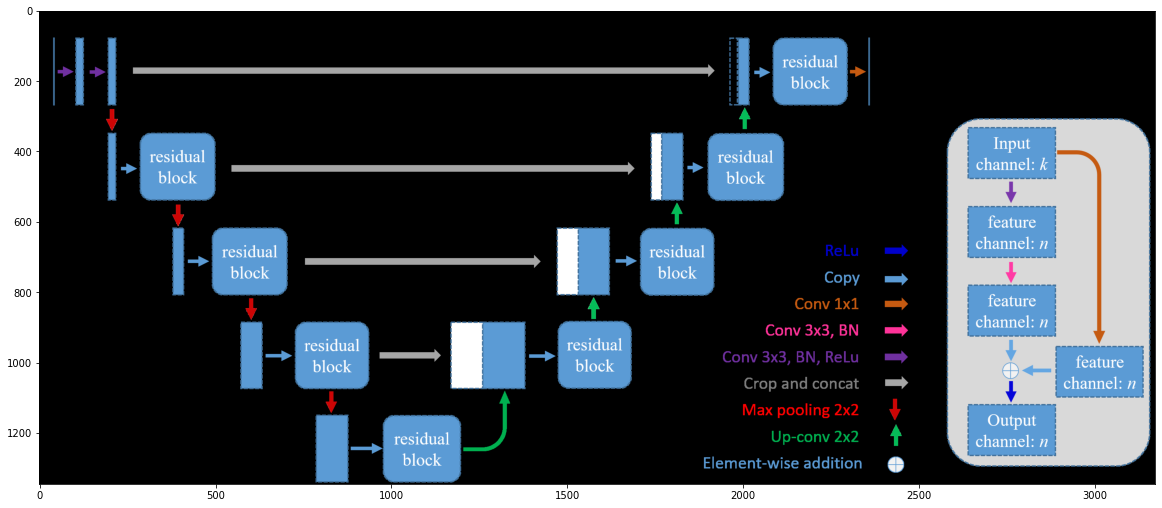

In [ ]:
seg_png = cv2.imread('/content/drive/My Drive/unet_resnet_strucutre_new.png')
plt.figure(figsize=(20,20))
plt.imshow(seg_png[..., [2,1,0]])
plt.show()

In [ ]:
import keras
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, UpSampling2D, Conv2D, MaxPooling2D, Concatenate, Activation
from keras import backend as K

# create the base pre-trained model
base_model = VGG16(weights='imagenet', input_shape=(256,256,3), include_top=False)
 
base_out = base_model.output

In [ ]:
base_out

<KerasTensor: shape=(None, 8, 8, 512) dtype=float32 (created by layer 'block5_pool')>

In [ ]:
base_model.summary(line_length=150)

Model: "vgg16"
______________________________________________________________________________________________________________________________________________________
Layer (type)                                                       Output Shape                                                Param #                
input_2 (InputLayer)                                               [(None, 256, 256, 3)]                                       0                      
______________________________________________________________________________________________________________________________________________________
block1_conv1 (Conv2D)                                              (None, 256, 256, 64)                                        1792                   
______________________________________________________________________________________________________________________________________________________
block1_conv2 (Conv2D)                                              (None, 256, 

In [ ]:
conv1 = base_model.get_layer('block1_conv2').output
conv2 = base_model.get_layer('block2_conv2').output
conv3 = base_model.get_layer('block3_conv3').output
conv4 = base_model.get_layer('block4_conv3').output
conv5 = base_model.get_layer('block5_conv3').output
output = base_model.get_layer('block5_pool').output

In [ ]:
up1 = UpSampling2D(2, interpolation='bilinear')(output)
conc_1 = Concatenate()([up1, conv5])
conv_conc_1 = Conv2D(512, (3, 3), padding='same')(conc_1)
conv_conc_1 = Activation('relu')(conv_conc_1)

up2 = UpSampling2D(2, interpolation='bilinear')(conv_conc_1)
conc_2 = Concatenate()([up2, conv4])
conv_conc_2 = Conv2D(256, (3, 3), padding='same')(conc_2)
conv_conc_2 = Activation('relu')(conv_conc_2)

up3 = UpSampling2D(2, interpolation='bilinear')(conv_conc_2)
conc_3 = Concatenate()([up3, conv3])
conv_conc_3 = Conv2D(128, (3, 3), padding='same')(conc_3)
conv_conc_3 = Activation('relu')(conv_conc_3)

up4 = UpSampling2D(2, interpolation='bilinear')(conv_conc_3)
conc_4 = Concatenate()([up4, conv2])
conv_conc_4 = Conv2D(64, (3, 3), padding='same')(conc_4)
conv_conc_4 = Activation('relu')(conv_conc_4)

up5 = UpSampling2D(2, interpolation='bilinear')(conv_conc_4)
conc_5 = Concatenate()([up5, conv1])
conv_conc_5 = Conv2D(32, (3, 3), padding='same')(conc_5)
conv_conc_5 = Activation('relu')(conv_conc_5)

conv_conc_6 = Conv2D(1, (3, 3), padding='same')(conv_conc_5)
conv_conc_6 = Activation('sigmoid')(conv_conc_6)


In [ ]:
conv_conc_6

<KerasTensor: shape=(None, 256, 256, 1) dtype=float32 (created by layer 'activation_75')>

In [ ]:
model = Model(inputs=base_model.input, outputs=conv_conc_6)

In [ ]:
best_w = keras.callbacks.ModelCheckpoint('resnet_best.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=True,
                                save_weights_only=True,
                                mode='auto',
                                period=1)

last_w = keras.callbacks.ModelCheckpoint('resnet_last.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=False,
                                save_weights_only=True,
                                mode='auto',
                                period=1)


callbacks = [best_w, last_w]



adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)


model.compile(adam, 'binary_crossentropy')

In [ ]:
batch_size = 8
model.fit(keras_generator(train_df, batch_size),
              steps_per_epoch=40,
              epochs=10,
              verbose=1,
              callbacks=callbacks,
              validation_data=keras_generator(val_df, batch_size),
              validation_steps=50,
              class_weight=None,
              max_queue_size=10,
              workers=1,
              use_multiprocessing=False,
              shuffle=True,
              initial_epoch=0)

Epoch 1/10
40/40 [==============================] - 27s 650ms/step - loss: 0.7107 - val_loss: 0.0382
Epoch 2/10
40/40 [==============================] - 25s 645ms/step - loss: 0.0306 - val_loss: 0.0199
Epoch 3/10
40/40 [==============================] - 25s 646ms/step - loss: 0.0204 - val_loss: 0.0182
Epoch 4/10
40/40 [==============================] - 25s 645ms/step - loss: 0.0155 - val_loss: 0.0162
Epoch 5/10
40/40 [==============================] - 26s 652ms/step - loss: 0.0149 - val_loss: 0.0151
Epoch 6/10
40/40 [==============================] - 25s 646ms/step - loss: 0.0195 - val_loss: 0.0194
Epoch 7/10
40/40 [==============================] - 26s 654ms/step - loss: 0.0166 - val_loss: 0.0146
Epoch 8/10
40/40 [==============================] - 26s 652ms/step - loss: 0.0146 - val_loss: 0.0138
Epoch 9/10
40/40 [==============================] - 26s 647ms/step - loss: 0.0127 - val_loss: 0.0132
Epoch 10/10
40/40 [==============================] - 25s 645ms/step - loss: 0.0120 - val_lo

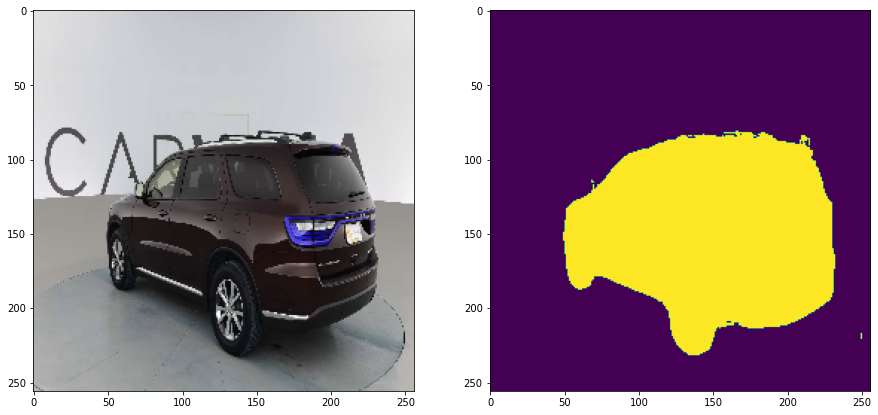

In [ ]:
pred = model.predict(x)

im_id = 5
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 15))
axes[0].imshow(x[im_id])
axes[1].imshow(pred[im_id, ..., 0] >0.5)

plt.show()